# Imputation and Integration for Mouse Brain data

## loading package

In [15]:
import scanpy as sc
import torch as th
import scanpy as sc
import pandas as pd
import torch.nn as nn

from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
file_fold = '/data/xiangdw/data/data/' 
from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
    "font.size":12,
    "axes.unicode_minus": False
}
rcParams.update(config)

## Imputation

In [ ]:

path = '/data/xiangdw/data/data/MouseBrain_new/'
a = []
layers_nums = 3
for i in range(1):

    seeds = i+1
    adata_omics2 = sc.read_h5ad(path + 'MouseBrain_RNA_concat.h5ad')
    adata_omics1 = sc.read_h5ad(path + 'MouseBrain_H3K27me3_concat.h5ad')
    
    #New spatial coord
    tissue_positions = pd.read_csv('/data/xiangdw/mousebrain/gtt_output/new_coord_modify.csv', header=None)

    cell_ids = tissue_positions.iloc[:, 0]
    x_coords = tissue_positions.iloc[:, 1]
    y_coords = tissue_positions.iloc[:, 2]

    x_coords_dict = dict(zip(cell_ids, x_coords))
    y_coords_dict = dict(zip(cell_ids, y_coords))

    adata_omics1.obs_names = adata_omics1.obs_names.str.replace('mousebrain#', '')
    adata_omics2.obs_names = adata_omics2.obs_names.str.replace('mousebrain#', '')

    adata_omics1.obs['x_coord'] = adata_omics1.obs.index.map(x_coords_dict).astype('float')
    adata_omics1.obs['y_coord'] = adata_omics1.obs.index.map(y_coords_dict).astype('float')
    adata_omics1.obsm['spatial'] = adata_omics1.obs[['x_coord', 'y_coord']].values
    adata_omics2.obs['x_coord'] = adata_omics2.obs['row'].values 
    adata_omics2.obs['y_coord'] = adata_omics2.obs['col'].values 
    adata_omics2.obsm['spatial'] = adata_omics2.obs[['x_coord', 'y_coord']].values

    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, adata_omics1, adata_omics2 = Sagegraph(modalities, device, datatype='Spatial_Epigenome_RNA', batch=True)
    output_dir = '/data/xiangdw/data/pred result/'
    weight = [0,1,2]

    pred_name = 'MouseBrain_SpaMIE_RNA_'+str(layers_nums)+'_pred.csv'
    true_name = 'MouseBrain_SpaMIE_RNA_'+str(layers_nums)+'_truth.csv'

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]
    train_size = adata_omics1[adata_omics1.obs['batch']=='1'].shape[0]

    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='prediction', datatype='Spatial_Epigenome_RNA',
                        layers_nums=int(layers_nums), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='mean', lr=2e-4, lr2 = 0.002)

    adata_omics1_pred, adata_omics2_pred, test_idx, train_idx,wt,alph  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1,  
                                                                                    output_dir=output_dir, pred_name=pred_name, 
                                                                                    true_name=true_name, train_size=train_size, weight=True, save_csv=False)



2025-10-17 15:29:31,977 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-17 15:30:16,370 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-17 15:30:16,514 - harmonypy - INFO - Iteration 1 of 10
2025-10-17 15:30:24,687 - harmonypy - INFO - Iteration 2 of 10
2025-10-17 15:30:33,012 - harmonypy - INFO - Iteration 3 of 10
2025-10-17 15:30:40,001 - harmonypy - INFO - Iteration 4 of 10
2025-10-17 15:30:45,364 - harmonypy - INFO - Iteration 5 of 10
2025-10-17 15:30:50,683 - harmonypy - INFO - Iteration 6 of 10
2025-10-17 15:30:56,000 - harmonypy - INFO - Iteration 7 of 10
2025-10-17 15:31:01,288 - harmonypy - INFO - Iteration 8 of 10
2025-10-17 15:31:08,336 - harmonypy - INFO - Iteration 9 of 10
2025-10-17 15:31:12,838 - harmonypy - INFO - Iteration 10 of 10
2025-10-17 15:31:17,571 - harmonypy - INFO - Stopped before convergence
/data/xiangdw/MODEL/SpaMIE/spamie_net.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated.

## Integration

In [ ]:
import os
import dgl
import pandas as pd
import sys
import scanpy as sc
import importlib 
import torch as th
import torch.nn as nn
from sklearn.utils import shuffle
from model_integration import *

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
     "font.size":20, 
    "axes.unicode_minus": False 
}
rcParams.update(config)

In [4]:
import torch.nn.functional as F
from SpaMIE.create_graph import Sagegraph
from SpaMIE.spamie_main import Sagewrapper
import numpy as np
from model_integration import set_seed
device = th.device('cuda:1' if th.cuda.is_available() else 'cpu')


for i in range(1): 
    seeds = str(i+1)
    path = '/data/xiangdw/data/data/MouseBrain_new/'
    adata_omics1 = sc.read_h5ad(path + 'MouseBrain_H3K27me3_concat.h5ad')
    adata_omics2 = sc.read_h5ad(path + 'MouseBrain_RNA_pred_concat.h5ad')
    set_seed(2024) 

    #New spatial coord
    tissue_positions = pd.read_csv('/data/xiangdw/mousebrain/gtt_output/new_coord_modify.csv', header=None)

    cell_ids = tissue_positions.iloc[:, 0]
    x_coords = tissue_positions.iloc[:, 1]
    y_coords = tissue_positions.iloc[:, 2]

    x_coords_dict = dict(zip(cell_ids, x_coords))
    y_coords_dict = dict(zip(cell_ids, y_coords))

    adata_omics1.obs_names = adata_omics1.obs_names.str.replace('mousebrain#', '')
    adata_omics2.obs_names = adata_omics2.obs_names.str.replace('mousebrain#', '')

    adata_omics1.obs['x_coord'] = adata_omics1.obs.index.map(x_coords_dict).astype('float')
    adata_omics1.obs['y_coord'] = adata_omics1.obs.index.map(y_coords_dict).astype('float')
    adata_omics1.obsm['spatial'] = adata_omics1.obs[['x_coord', 'y_coord']].values
    adata_omics2.obs['x_coord'] = adata_omics2.obs['row'].values 
    adata_omics2.obs['y_coord'] = adata_omics2.obs['col'].values 
    adata_omics2.obsm['spatial'] = adata_omics2.obs[['x_coord', 'y_coord']].values

    modalities = [adata_omics1, adata_omics2]
    g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, adata_omics1, adata_omics2 = Sagegraph(modalities, device, task="Integration", datatype="Spatial_Epigenome_RNA",batch=True)

    in_feat = adata_omics1.obsm['feat'].shape[1]
    out_feat = adata_omics2.X.shape[1]
    weight = [1,1,1]
    model = Sagewrapper(seed=(int(seeds)), device=device, in_feat=in_feat, n_hidden=256, out_feat=out_feat, task='integration', datatype='Spatial_Epigenome_RNA',
                        layers_nums=int(3), weight=weight, epoch=600, res_type='res_add', activation=nn.LeakyReLU
                        , sagetype='mean', lr=2e-4, lr2 = 0.002)

    output  = model.fit(adata_omics1, adata_omics2, g_spatial_omics1, g_feature_omics1, g_spatial_omics2, g_feature_omics2, weight_factors=[2,1,1,1])

    adata_omics2.obsm['SpaMIE'] = output[0]
    

2025-10-17 15:32:22,090 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-17 15:32:54,144 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-17 15:32:54,200 - harmonypy - INFO - Iteration 1 of 10
2025-10-17 15:33:02,155 - harmonypy - INFO - Iteration 2 of 10
2025-10-17 15:33:09,790 - harmonypy - INFO - Iteration 3 of 10
2025-10-17 15:33:16,496 - harmonypy - INFO - Iteration 4 of 10
2025-10-17 15:33:21,819 - harmonypy - INFO - Iteration 5 of 10
2025-10-17 15:33:27,183 - harmonypy - INFO - Iteration 6 of 10
2025-10-17 15:33:32,600 - harmonypy - INFO - Iteration 7 of 10
2025-10-17 15:33:37,952 - harmonypy - INFO - Iteration 8 of 10
2025-10-17 15:33:45,007 - harmonypy - INFO - Iteration 9 of 10
2025-10-17 15:33:50,464 - harmonypy - INFO - Iteration 10 of 10
2025-10-17 15:33:55,879 - harmonypy - INFO - Stopped before convergence
2025-10-17 15:34:14,333 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-17 15:34:48,

## Visualisation

Searching resolution...
resolution=1.101, cluster number=9
resolution=1.001, cluster number=8


/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/xiangdw/conda_env/GNNS/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'SpaMIE'}, xlabel='spatial1', ylabel='spatial2'>

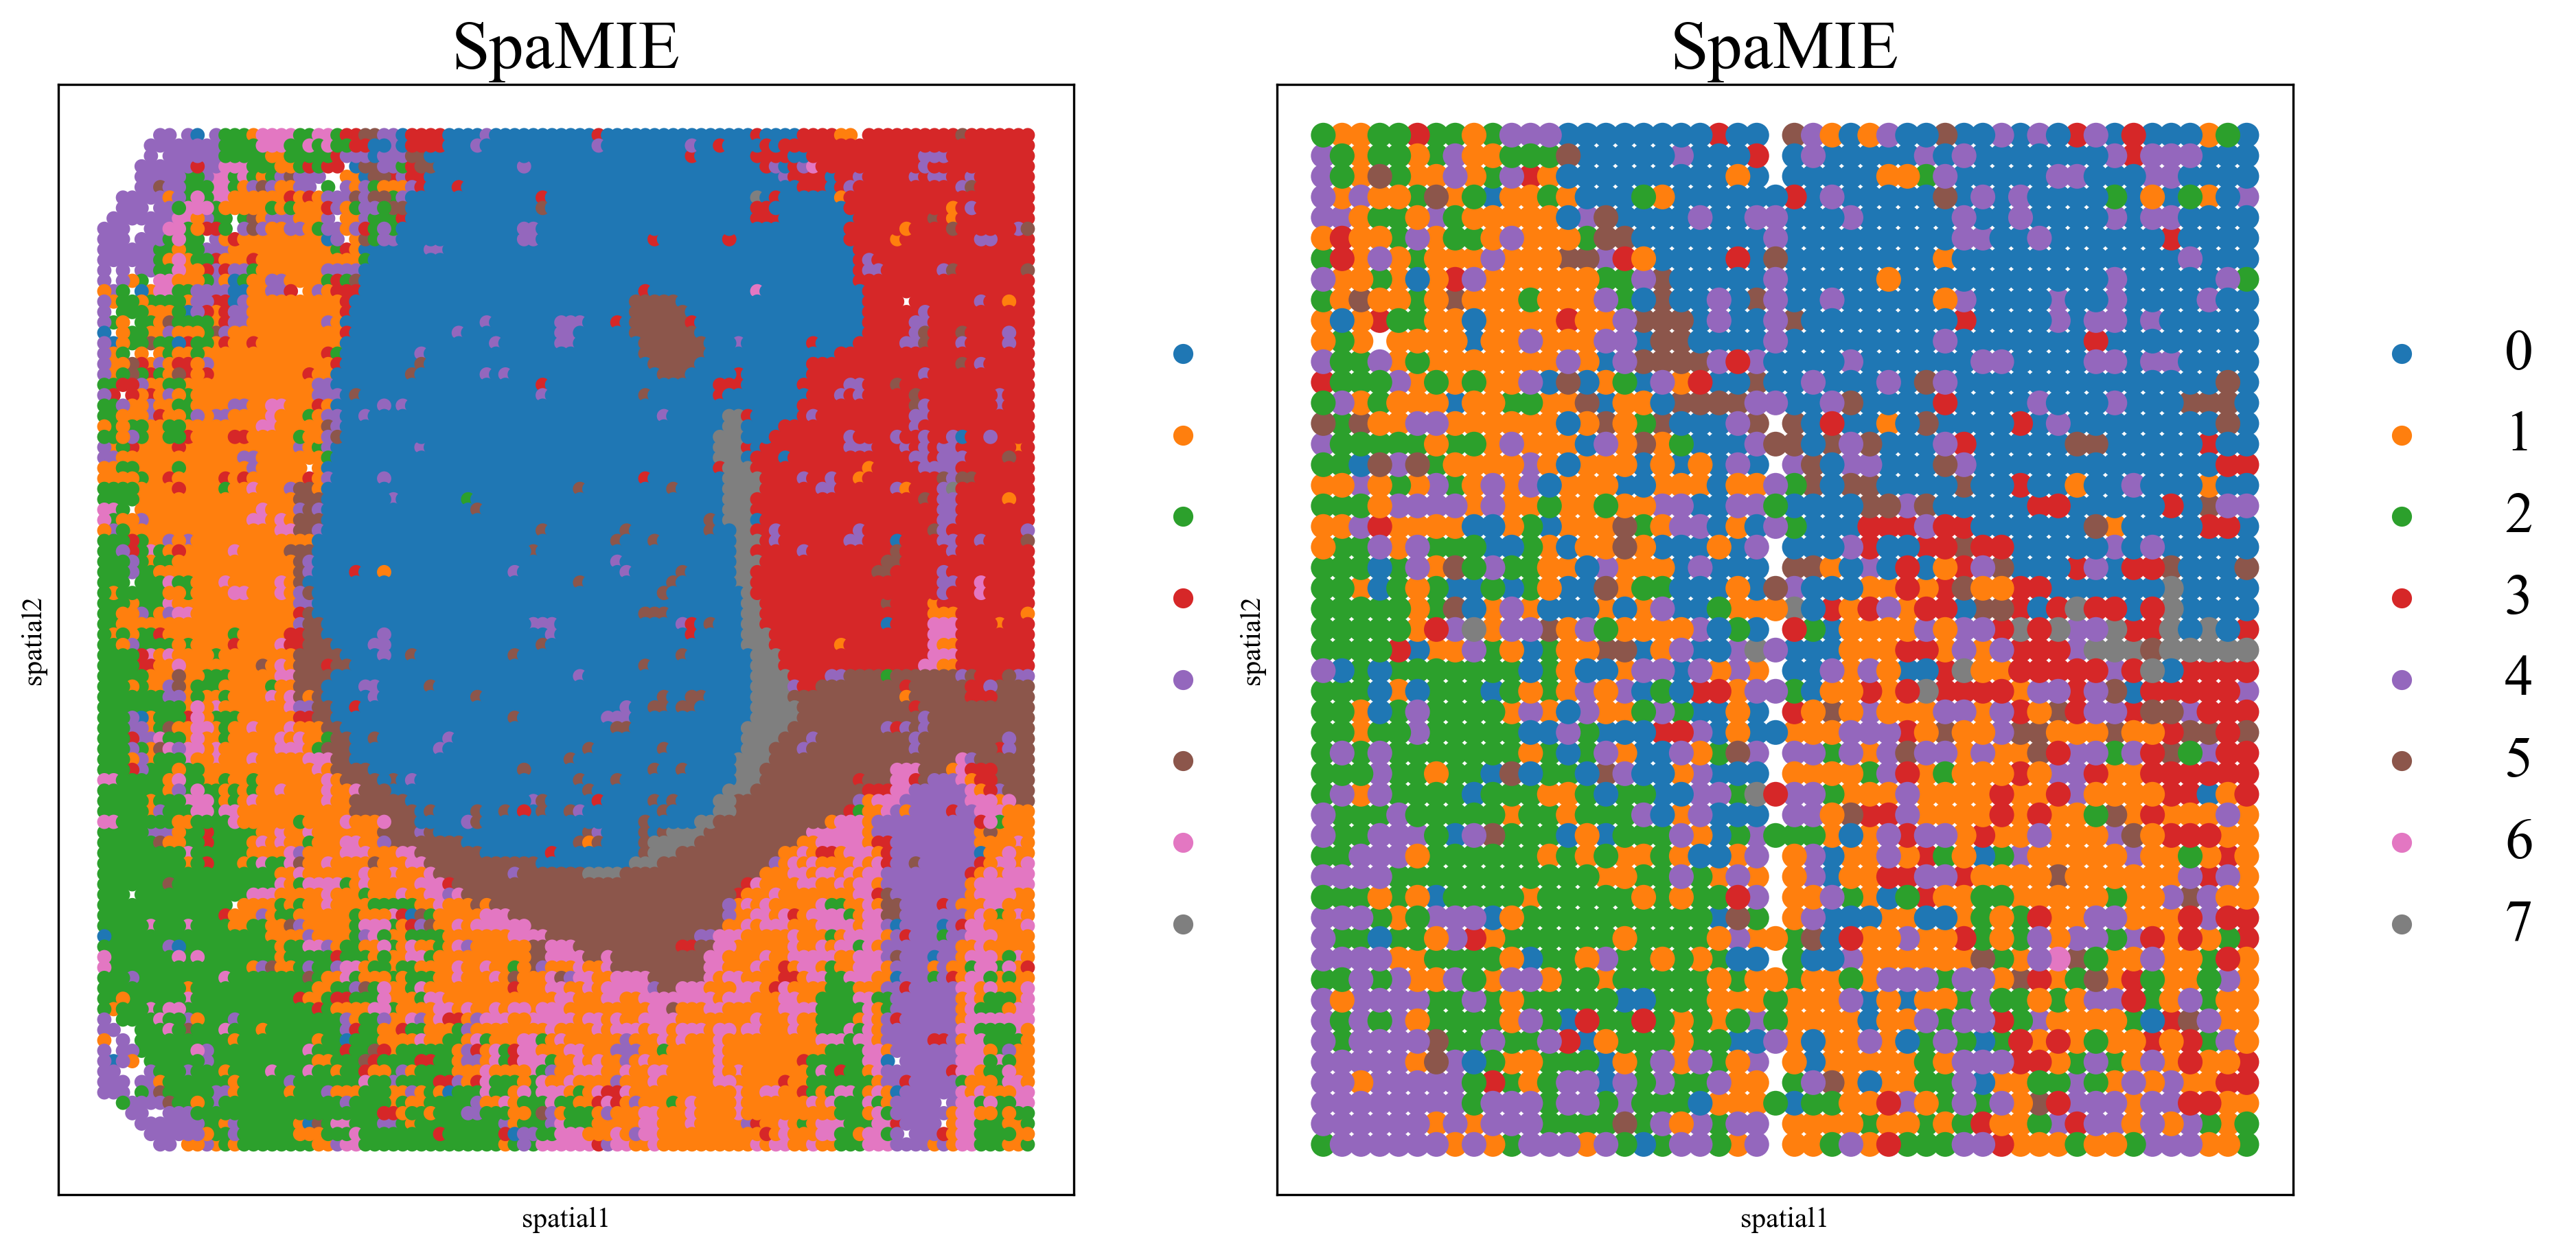

In [14]:
from SpatialGlue.utils import clustering
fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=300)
plt.rcParams['font.size'] = 20
tool = 'louvain'
path = '/data/xiangdw/data/data/MouseBrain_new/'
adata = sc.read_h5ad(path + "MouseBrain_concat_methods.h5ad")
adata.obsm['spatial'] = adata.obs[['row', 'col']].values
clustering(adata_omics2, key='SpaMIE', add_key='SpaMIE',start=0.001, end=1.2, increment=0.1, n_clusters=8, method=tool, use_pca=False)
adata.obsm['SpaMIE'] = adata_omics2.obs['SpaMIE'].copy()
adata1 = adata[adata.obs['batch'] == '1'].copy()
adata2 = adata[adata.obs['batch'] == '2'].copy()
sc.pl.embedding(adata1, basis='spatial', color=['SpaMIE_pred_1'], ax=axs[0], title='SpaMIE', s=100, show=False)
sc.pl.embedding(adata2, basis='spatial', color=['SpaMIE_pred_1'], ax=axs[1], title='SpaMIE', s=300, show=False)